# **Prophet model**

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from prophet import Prophet

from sklearn.metrics import mean_absolute_error, mean_squared_error

import sys
sys.path.append('../src')
from utils import *

In [6]:
# Read preprocessed data
data_raw = pd.read_csv('../data/processed/final_data.csv', index_col='Unnamed: 0', parse_dates=['date_etablissement_dpe'])

In [7]:

# Split data according to category
data = split(data_raw)

Let's take a look at the unique dates to have an idea of the size of our time series.

In [8]:
for key in data.keys():
    print(f'Column: {key}'.ljust(19, ' ') + '--->' + f'Size = {data[key].date_etablissement_dpe.unique().shape[0]}'.rjust(12, ' '))

Column: admin      ---> Size = 4252
Column: centre_com ---> Size = 3418
Column: occup_cont ---> Size = 3246
Column: autre      ---> Size = 4043


**Aggregating columns with respect to the date column**

In [10]:
ts ={key: {freq: extract_vect_ts(df, freq) for freq in ['D', 'W', 'ME']} for key, df in data.items()}

In [11]:
ts['admin']['W']  # ts['sector']['frequency']

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2013-01-13,1974.000000,100.000000,661276.385727,6.863710e+06,27.130000
2013-01-20,1974.000000,100.000000,642131.351753,6.841609e+06,27.515000
2013-01-27,1974.000000,100.000000,622986.317779,6.819508e+06,27.900000
2013-02-03,1974.000000,100.000000,603841.283805,6.797406e+06,28.285000
2013-02-10,1974.000000,100.000000,584696.249830,6.775305e+06,28.670000
...,...,...,...,...,...
2024-12-08,1966.110170,234.024132,675958.215238,6.663887e+06,11.360938
2024-12-15,1966.023341,177.840398,661427.597506,6.661860e+06,8.770826
2024-12-22,1965.049847,173.369254,651383.875067,6.653682e+06,9.580173


_Remark:_ For the resampling step, only 156 rows out of our 4375 rows were interpolated, the remaining rows were already present in the dataset.

**Prediction and validation**

Before predicting let's define a function that splits our data into a train time series and test time series (it can be found in `aggregate.py`).

Now let's apply our model to predict ts_admin values. First let's do a train test split for every time series.

In [12]:
for sect in ts:
    for freq in ts[sect]:
        train, test = ttsplit(ts[sect][freq],test_size=0.15)
        ts[sect][freq] = {'train': train, 'test': test}

In [13]:
ts['admin']['W']['train'].tail()

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2023-02-19,1961.930918,310.578354,679762.800618,6.704718e+06,11.991879
2023-02-26,1966.448198,258.482166,672940.993864,6.647513e+06,13.280765
2023-03-05,1964.896711,238.914673,639655.996045,6.650743e+06,12.349130
2023-03-12,1967.450409,299.359822,646461.545600,6.659405e+06,13.285918
2023-03-19,1968.310557,409.674144,635086.366758,6.702488e+06,11.655385


In [14]:
ts['admin']['W']['test'].head()

,annee_construction,surface_utile,coord_x,coord_y,emission_ges
date_etablissement_dpe,,,,,
2023-03-26,1963.841848,226.918542,651089.831946,6.660787e+06,12.754762
2023-04-02,1964.295256,493.461595,671562.916629,6.636986e+06,9.278225
2023-04-09,1962.793442,277.382946,649888.803450,6.639849e+06,12.339568
2023-04-16,1965.087091,253.295260,664870.405874,6.654797e+06,11.778456
2023-04-23,1960.572276,257.582624,654913.671467,6.681319e+06,11.220162


We prepare the data for Prophet model

In [15]:
## Prophet nomenclature
def Prophetnom(df):
    df.reset_index(inplace=True)
    df.rename(columns={'date_etablissement_dpe':'ds','emission_ges':'y'}, inplace=True)

Prophetnom(ts['admin']['W']['train'])
Prophetnom(ts['centre_com']['W']['train'])
Prophetnom(ts['autre']['W']['train'])
Prophetnom(ts['occup_cont']['W']['train'])

Prophetnom(ts['admin']['W']['test'])
Prophetnom(ts['centre_com']['W']['test'])
Prophetnom(ts['autre']['W']['test'])
Prophetnom(ts['occup_cont']['W']['test'])


In [16]:
ts_admin_W_all=pd.concat([ts['admin']['W']['train'],ts['admin']['W']['test']]).reset_index(drop=True)
ts_centre_com_W_all=pd.concat([ts['centre_com']['W']['train'],ts['centre_com']['W']['test']]).reset_index(drop=True)
ts_autre_W_all=pd.concat([ts['autre']['W']['train'],ts['autre']['W']['test']]).reset_index(drop=True)
ts_occup_cont_W_all=pd.concat([ts['occup_cont']['W']['train'],ts['occup_cont']['W']['test']]).reset_index(drop=True)

ts_admin_W_all.head()

,ds,annee_construction,surface_utile,coord_x,coord_y,y
0,2013-01-13,1974.0,100.0,661276.385727,6.863710e+06,27.130
1,2013-01-20,1974.0,100.0,642131.351753,6.841609e+06,27.515
2,2013-01-27,1974.0,100.0,622986.317779,6.819508e+06,27.900
3,2013-02-03,1974.0,100.0,603841.283805,6.797406e+06,28.285
4,2013-02-10,1974.0,100.0,584696.249830,6.775305e+06,28.670


Here, we create the model and we fit it

In [17]:
# Model for each category

model_admin=Prophet()
model_centre_com=Prophet()
model_autre=Prophet()
model_occup_cont=Prophet()

################################ Adding regressors => Uncomment for Approach 2 ################################
"""
model_admin.add_regressor('annee_construction')
model_admin.add_regressor('surface_utile')
model_admin.add_regressor('coord_x')
model_admin.add_regressor('coord_y')

model_centre_com.add_regressor('annee_construction')
model_centre_com.add_regressor('surface_utile')
model_centre_com.add_regressor('coord_x')
model_centre_com.add_regressor('coord_y')

model_autre.add_regressor('annee_construction')
model_autre.add_regressor('surface_utile')
model_autre.add_regressor('coord_x')
model_autre.add_regressor('coord_y')

model_occup_cont.add_regressor('annee_construction')
model_occup_cont.add_regressor('surface_utile')
model_occup_cont.add_regressor('coord_x')
model_occup_cont.add_regressor('coord_y')

"""
# Fitting 

model_admin.fit(ts['admin']['W']['train'])
model_centre_com.fit(ts['centre_com']['W']['train'])
model_autre.fit(ts['autre']['W']['train'])
model_occup_cont.fit(ts['occup_cont']['W']['train'])

23:53:40 - cmdstanpy - INFO - Chain [1] start processing
23:53:41 - cmdstanpy - INFO - Chain [1] done processing
23:53:41 - cmdstanpy - INFO - Chain [1] start processing
23:53:41 - cmdstanpy - INFO - Chain [1] done processing
23:53:42 - cmdstanpy - INFO - Chain [1] start processing
23:53:42 - cmdstanpy - INFO - Chain [1] done processing
23:53:42 - cmdstanpy - INFO - Chain [1] start processing
23:53:42 - cmdstanpy - INFO - Chain [1] done processing


In [18]:
# The forecast

future_admin=ts_admin_W_all.drop(columns='y')
future_centre_com=ts_centre_com_W_all.drop(columns='y')
future_autre=ts_autre_W_all.drop(columns='y')
future_occup_cont=ts_occup_cont_W_all.drop(columns='y')

forecast_admin = model_admin.predict(future_admin)
forecast_centre_com = model_centre_com.predict(future_centre_com)
forecast_autre = model_autre.predict(future_autre)
forecast_occup_cont = model_occup_cont.predict(future_occup_cont)

## **Now, we plot predictions and calculate errors metrics for each category**

#### Plotting GES emmissions VS Time, for predictions and real values (admin)

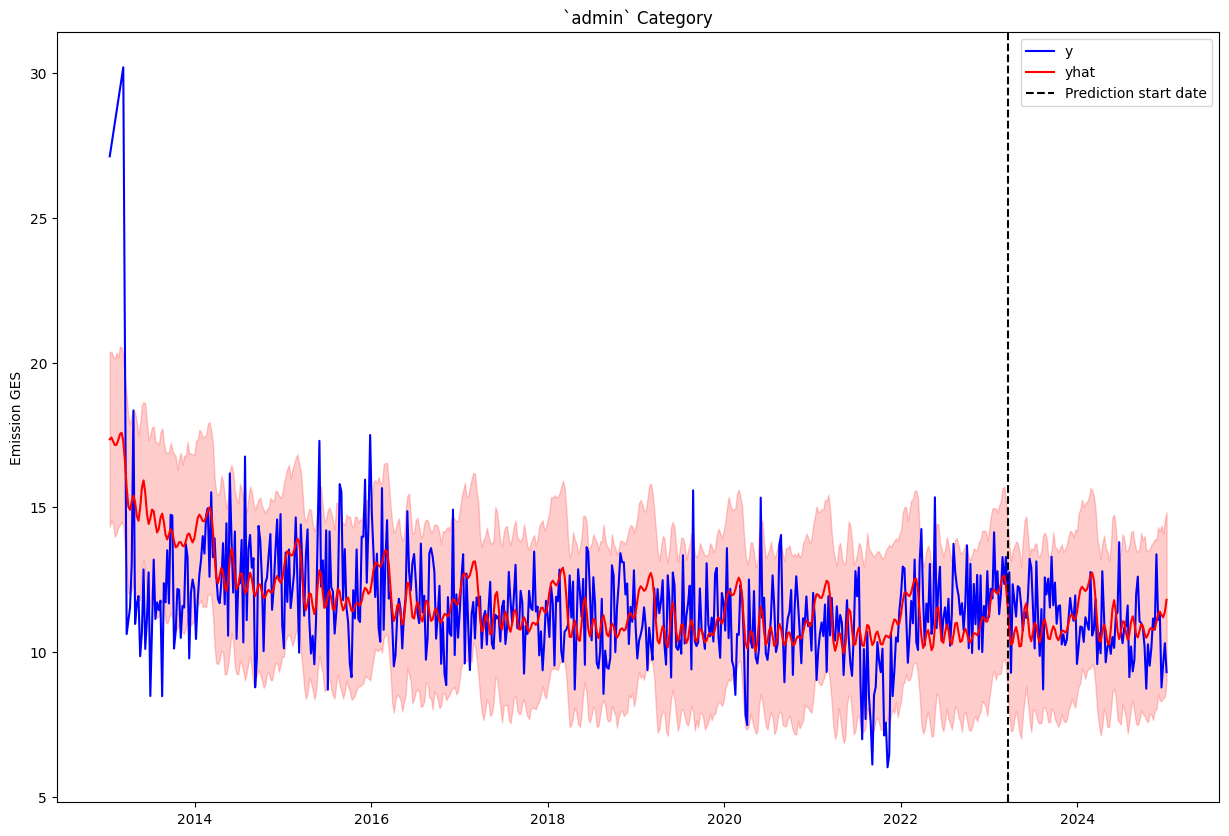

In [19]:
fig=plt.figure(figsize=(15,10))

plt.plot(ts_admin_W_all["ds"], ts_admin_W_all["y"], label="y", color="blue")

plt.plot(forecast_admin["ds"], forecast_admin["yhat"], label="yhat", color="red")

plt.axvline(x=list(ts['admin']['W']['train'].ds)[-1], color="black", linestyle="--",label="Prediction start date")

plt.fill_between(forecast_admin["ds"], forecast_admin["yhat_lower"], forecast_admin["yhat_upper"], color="red", alpha=0.2)

plt.ylabel("Emission GES")

plt.legend()

plt.title("`admin` Category")

plt.show()

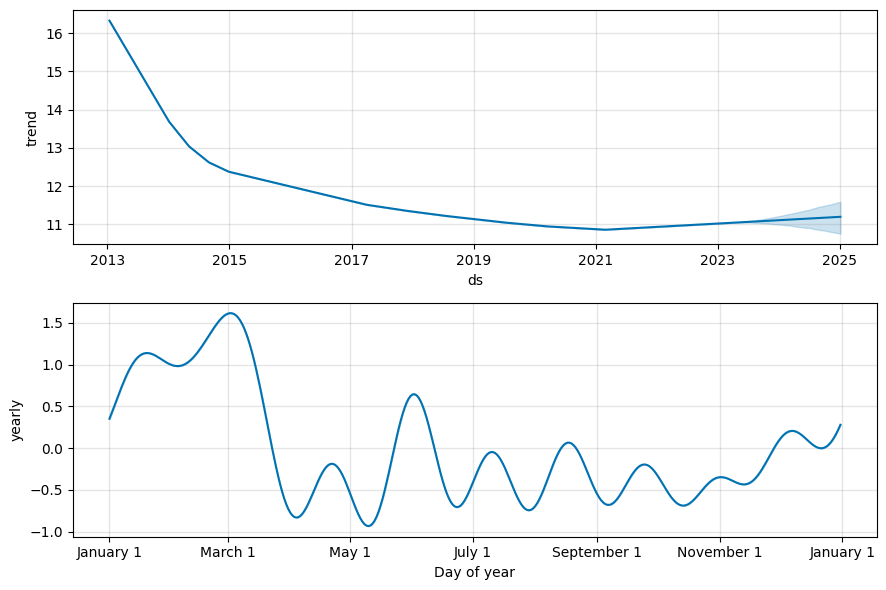

In [20]:
model_admin.plot_components(forecast_admin)
plt.show()

#### Compute error metrics

In [21]:
mae = mean_absolute_error(ts['admin']['W']['test']["y"], forecast_admin["yhat"][ts['admin']['W']['train'].shape[0]:])
rmse = np.sqrt(mean_squared_error(ts['admin']['W']['test']["y"], forecast_admin["yhat"][ts['admin']['W']['train'].shape[0]:]))

# Print results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1.05
RMSE: 1.32


#### Plotting GES emmissions VS Time, for predictions and real values (autre)

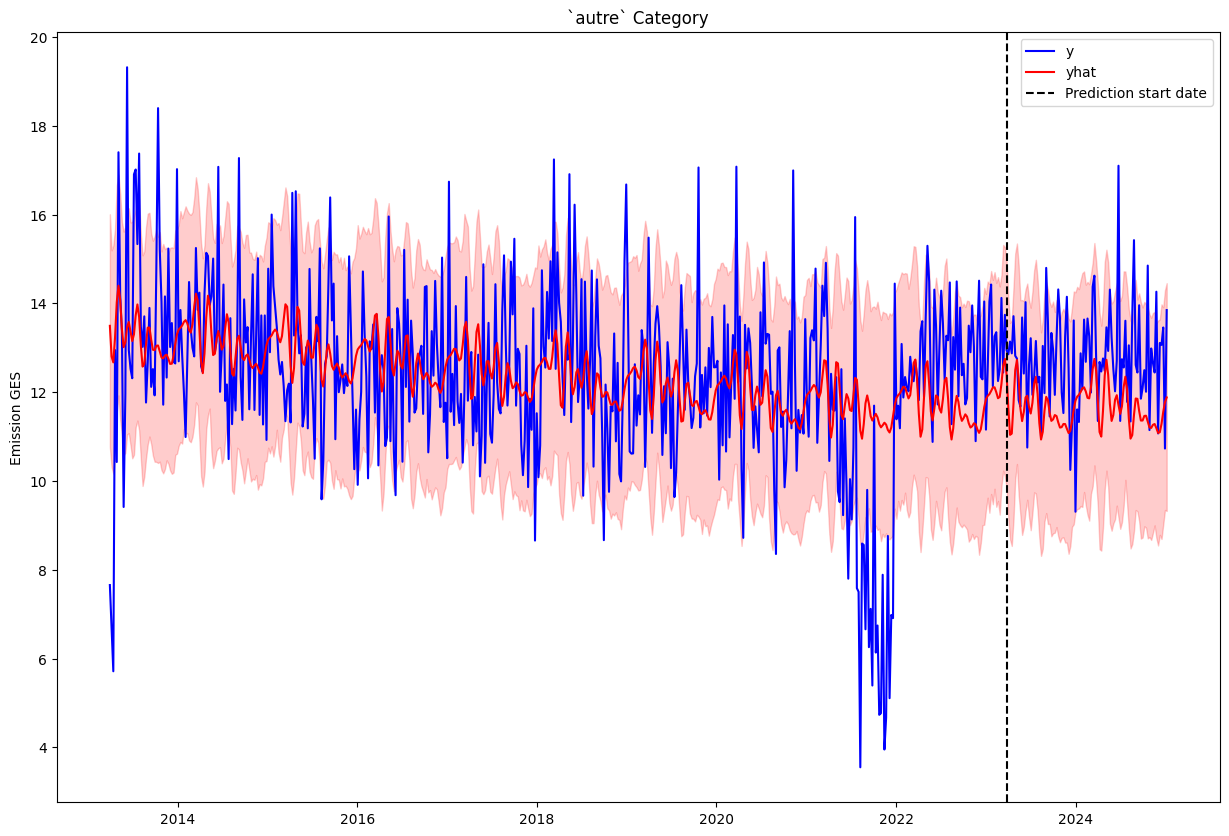

In [22]:
fig=plt.figure(figsize=(15,10))

plt.plot(ts_autre_W_all["ds"], ts_autre_W_all["y"], label="y", color="blue")

plt.plot(forecast_autre["ds"], forecast_autre["yhat"], label="yhat", color="red")

plt.axvline(x=list(ts['autre']['W']['train'].ds)[-1], color="black", linestyle="--",label="Prediction start date")

plt.fill_between(forecast_autre["ds"], forecast_autre["yhat_lower"], forecast_autre["yhat_upper"], color="red", alpha=0.2)

plt.legend()

plt.ylabel("Emission GES")

plt.title("`autre` Category")

plt.show()

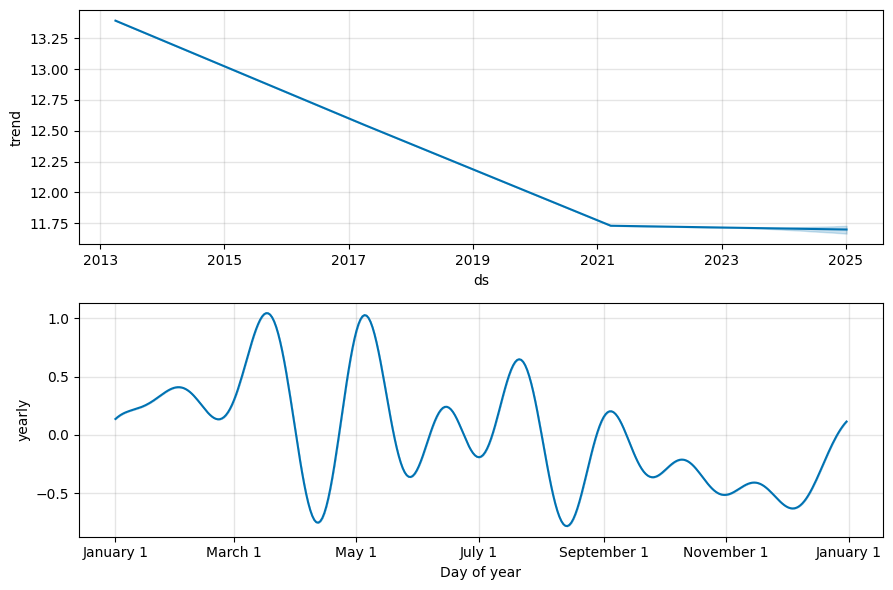

In [23]:
model_autre.plot_components(forecast_autre)
plt.show()

#### Compute error metrics

In [24]:
mae = mean_absolute_error(ts['autre']['W']['test']["y"], forecast_autre["yhat"][ts['autre']['W']['train'].shape[0]:])
rmse = np.sqrt(mean_squared_error(ts['autre']['W']['test']["y"], forecast_autre["yhat"][ts['autre']['W']['train'].shape[0]:]))

# Print results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1.27
RMSE: 1.62


#### Plotting GES emmissions VS Time, for predictions and real values (centre_com)

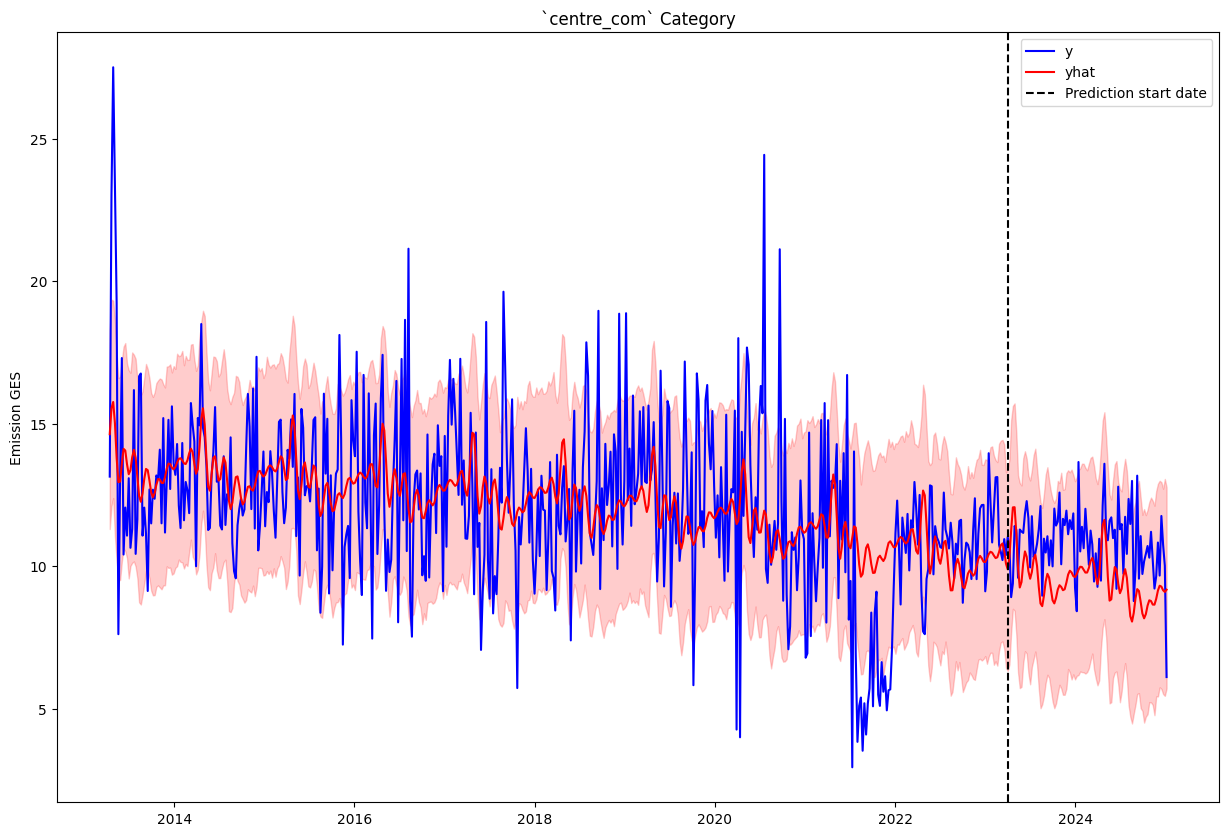

In [25]:
fig=plt.figure(figsize=(15,10))

plt.plot(ts_centre_com_W_all["ds"], ts_centre_com_W_all["y"], label="y", color="blue")

plt.plot(forecast_centre_com["ds"], forecast_centre_com["yhat"], label="yhat", color="red")

plt.axvline(x=list(ts['centre_com']['W']['train'].ds)[-1], color="black", linestyle="--",label="Prediction start date")

plt.fill_between(forecast_centre_com["ds"], forecast_centre_com["yhat_lower"], forecast_centre_com["yhat_upper"], color="red", alpha=0.2)

plt.legend()

plt.ylabel("Emission GES")

plt.title("`centre_com` Category")

plt.show()

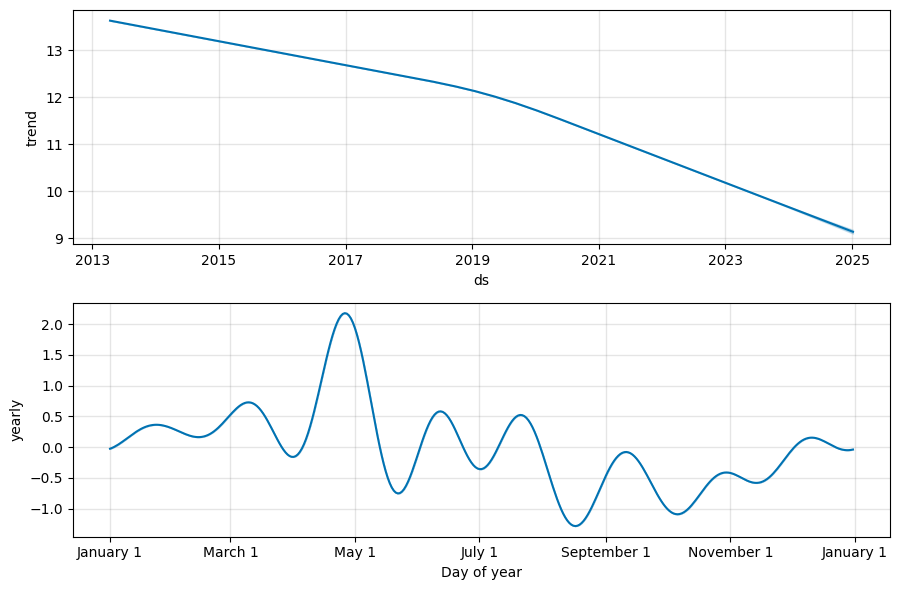

In [26]:
model_centre_com.plot_components(forecast_centre_com)
plt.show()

#### Compute error metrics

In [27]:
mae = mean_absolute_error(ts['centre_com']['W']['test']["y"], forecast_centre_com["yhat"][ts['centre_com']['W']['train'].shape[0]:])
rmse = np.sqrt(mean_squared_error(ts['centre_com']['W']['test']["y"], forecast_centre_com["yhat"][ts['centre_com']['W']['train'].shape[0]:]))

# Print results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1.58
RMSE: 1.89


#### Plotting GES emmissions VS Time, for predictions and real values (occup_cont)

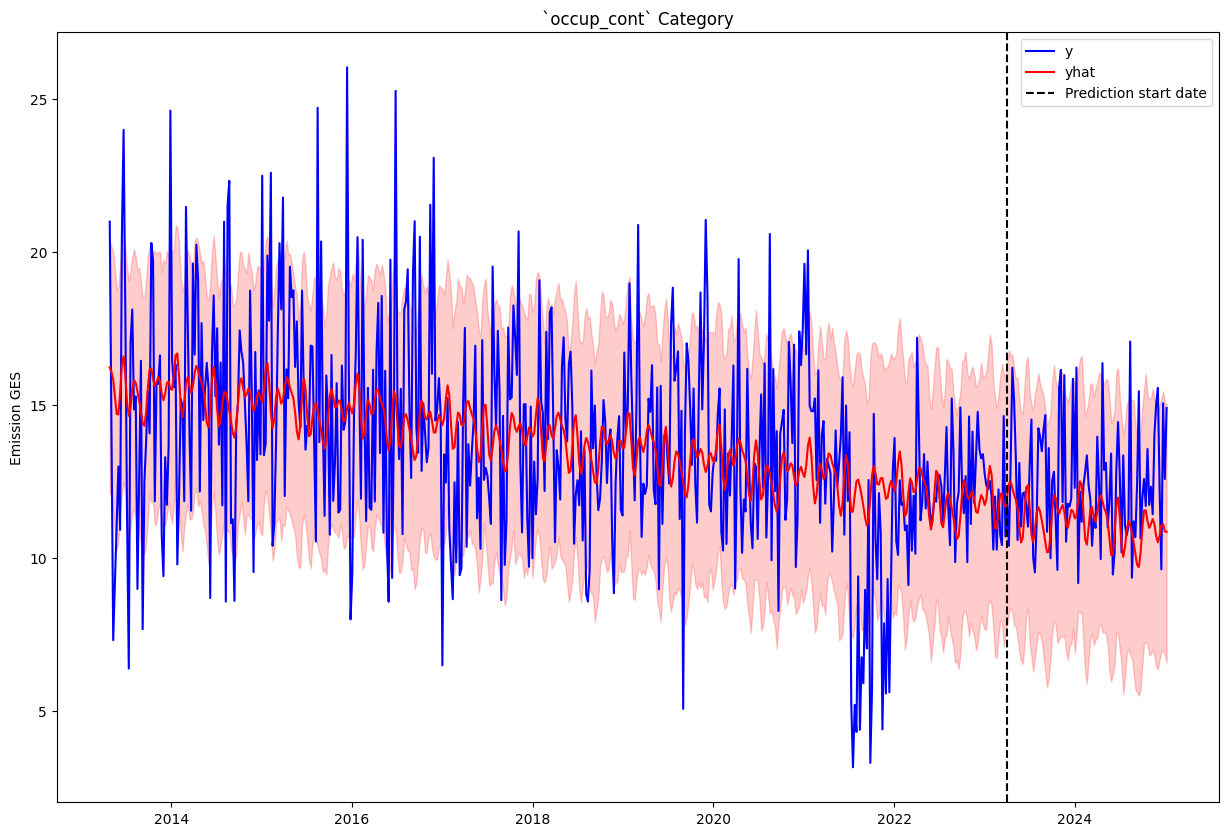

In [28]:
fig=plt.figure(figsize=(15,10))

plt.plot(ts_occup_cont_W_all["ds"], ts_occup_cont_W_all["y"], label="y", color="blue")

plt.plot(forecast_occup_cont["ds"], forecast_occup_cont["yhat"], label="yhat", color="red")

plt.axvline(x=list(ts['occup_cont']['W']['train'].ds)[-1], color="black", linestyle="--",label="Prediction start date")

plt.fill_between(forecast_occup_cont["ds"], forecast_occup_cont["yhat_lower"], forecast_occup_cont["yhat_upper"], color="red", alpha=0.2)

plt.legend()

plt.ylabel("Emission GES")

plt.title("`occup_cont` Category")

plt.show()

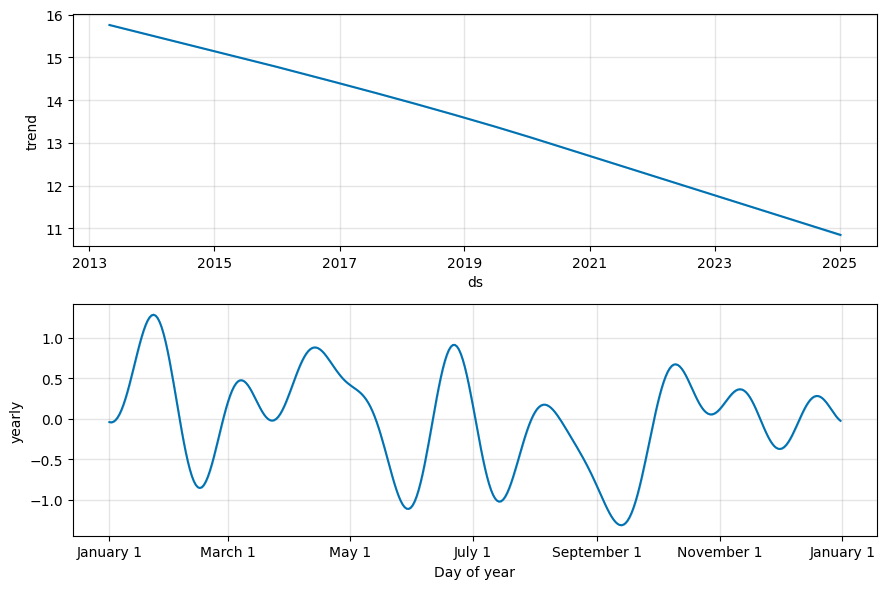

In [29]:
model_occup_cont.plot_components(forecast_occup_cont)
plt.show()

#### Compute error metrics

In [30]:
mae = mean_absolute_error(ts['occup_cont']['W']['test']["y"], forecast_occup_cont["yhat"][ts['occup_cont']['W']['train'].shape[0]:])
rmse = np.sqrt(mean_squared_error(ts['occup_cont']['W']['test']["y"], forecast_occup_cont["yhat"][ts['occup_cont']['W']['train'].shape[0]:]))

# Print results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 1.81
RMSE: 2.34
